# Longitude, Latitude, Tilt and Azimuth Estimation Example

_Bennet Meyers, Alejandro Londono
08/04/2021

This notebook demonstrates the usage of the `ConfigurationEstimator` class to estimate latitude, longitude, tilt and azimuth from field data. NIST provides data from a collection of fully instrumented and documented arrays installed at their Maryland campus. These arrays have known latitude, longitude, tilt, and azimuth parameters. The data is publicly available [here](https://doi.org/10.18434/M3S67G), and documentation of the systems is provided [here](http://dx.doi.org/10.6028/NIST.TN.1896). In preparation for this work, I downloaded the available data, which is provided in daily CSV files cover a time span of 4 years, separated by system (ground, canopy, roof, and the two meteorological stations). I extracted the power and irradiance columns from these 6937 individual CSV files, and combined them to generate a single table spanning four years. The resulting `pickle` file is about 1.1GB in size, and is available from [my personal OneDrive](https://office365stanford-my.sharepoint.com/:u:/g/personal/bennetm_stanford_edu/EZ6bR4CFT8BJoa6NHG8y6jEBnGwR5IKf7W0CTic-RCph-g?e=8VoEj3).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Standard Imports
import pandas as pd
from geopy.distance import great_circle
from glob import glob
from time import time
# Solar Data Tools imports
from solardatatools import DataHandler
# pv-system-profiler imports
import sys
sys.path.append('..')
sys.path.append('../../Documents/github/pv-system-profiler')
from pvsystemprofiler.estimator import ConfigurationEstimator

# Configuration information from the published documentation:

In [3]:
ground_system_configuration = {
    'longitude': -77.2141,
    'latitude': 39.1319,
    'tilt': 20,
    'azimuth': 0,
}

# Load in 4-year data file, derived from NIST CSV files.

In [4]:
try:
    df = pd.read_pickle('~/pvinsight/scripts/data/NIST_all_power_and_irradiance_with_current.pkl')
except FileNotFoundError:
    print('Please download example data file to working directory')

# Utilize standard `solar-data-tools` preprocessing pipeline.

## Using AC power signal

total time: 38.05 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              19.81s
Cleaning                   14.88s
Filtering/Summarizing      3.36s
    Data quality           0.72s
    Clear day detect       0.39s
    Clipping detect        0.36s
    Capacity change detect 1.89s

Length:                4.00 years
Capacity estimate:     30.13 kW
Data sampling:         1.0 minute
Data quality score:    92.1%
Data clearness score:  15.7%
Inverter clipping:     False
Time shifts corrected: True
Time zone correction:  None


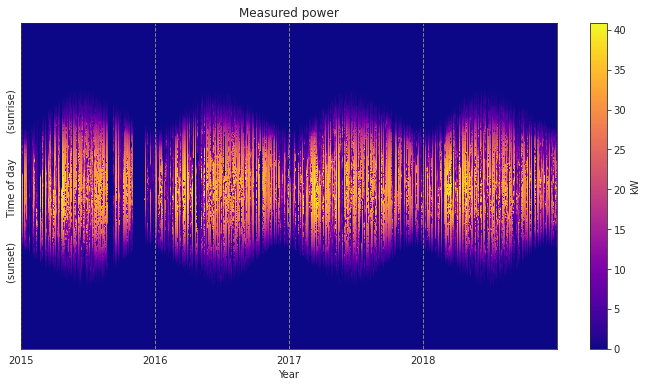

In [5]:
dh_ac_power = DataHandler(df)
dh_ac_power.run_pipeline(power_col=('ground', 'ShuntPDC_kW_Avg_4'))
dh_ac_power.report()
dh_ac_power.plot_heatmap(matrix='filled');

## Using DC current signal

In [6]:
dh_dc_current = DataHandler(df)
dh_dc_current.run_pipeline(power_col= ('ground', 'ShuntCurrent_A_Avg_4'), verbose=False)

# Initialize estimator class with the data handler instance and timezone information.

In [7]:
est_power = ConfigurationEstimator(dh_ac_power, gmt_offset=-5)
est_current = ConfigurationEstimator(dh_dc_current, gmt_offset=-5)

# Estimate longitude using default keyboard arguments:

## Using AC power signal

In [8]:
est = est_power
est.estimate_longitude()
lon = est.longitude

m1 = 'Real Longitude:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'Estimated Longitude:  {:.2f}\n'.format(est.longitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['longitude'] - est.longitude)
print(m1)

Real Longitude:  -77.21
Estimated Longitude:  -77.59
error:       0.37


## Using DC current signal

In [9]:
est = est_current
est.estimate_longitude()
lon = est.longitude

m1 = 'Real Longitude:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'Estimated Longitude:  {:.2f}\n'.format(est.longitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['longitude'] - est.longitude)
print(m1)

Real Longitude:  -77.21
Estimated Longitude:  -77.62
error:       0.40


# Estimate longitude using Haghdadi's published method of taking the median of daily estimates:

In [10]:
est = est_power

In [11]:
est.estimate_longitude(estimator='calculated', eot_calculation=('da_rosa'),)
lon = est.longitude
m1 = 'real lon:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'est  lon:  {:.2f}\n'.format(est.longitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['longitude'] - est.longitude)
print(m1)

real lon:  -77.21
est  lon:  -77.55
error:       0.34


# Estimate longitude using cost-function minimization method, with a Huber cost.

In [12]:
est.estimate_longitude(estimator='fit_huber')

m1 = 'Real Longitude:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'Estimated Longitude:  {:.2f}\n'.format(est.longitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['longitude'] - est.longitude)
print(m1)

Real Longitude:  -77.21
Estimated Longitude:  -77.49
error:       0.28


# Estimate latitude using default keyboard arguments

## Using AC power signal

In [13]:
est = est_power
est.estimate_latitude()

m1 = 'Real Latitude:  {:.2f}\n'.format(ground_system_configuration['latitude'])
m1 += 'Estimated  Latitude:  {:.2f}\n'.format(est.latitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['latitude'] - est.latitude)
print(m1)

Real Latitude:  39.13
Estimated  Latitude:  43.07
error:       -3.94


## Using DC current signal

In [14]:
est_current = ConfigurationEstimator(dh_dc_current, gmt_offset=-5)

In [15]:
est = est_current
est.estimate_latitude()

m1 = 'Real Latitude:  {:.2f}\n'.format(ground_system_configuration['latitude'])
m1 += 'Estimated  Latitude:  {:.2f}\n'.format(est.latitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['latitude'] - est.latitude)
print(m1)

Real Latitude:  39.13
Estimated  Latitude:  43.20
error:       -4.07


# Estimate latitude using sunrise-sunset method to calculate daylight hours

In [16]:
est_current = ConfigurationEstimator(dh_dc_current, gmt_offset=-5, daylight_method='sunrise-sunset')

In [17]:
est_current.estimate_latitude()
m1 = 'real lat:  {:.2f}\n'.format(ground_system_configuration['latitude'])
m1 += 'est  lat:  {:.2f}\n'.format(est.latitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['latitude'] - est.latitude)
print(m1)

real lat:  39.13
est  lat:  43.20
error:       -4.07


/Users/londonoh/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


# Estimate error in miles for Longitude and Latitude Calculation

In [18]:
est = ConfigurationEstimator(dh_ac_power, gmt_offset=-5)
est.estimate_longitude()
est.estimate_latitude()

lon = est.longitude
lat = est.latitude
ground_coord = (ground_system_configuration['latitude'], ground_system_configuration['longitude'])
estimated_coord = (lat, lon)
error_dist = great_circle(estimated_coord, ground_coord).miles
m1 = 'Longitude error (Degrees):       {:.2f}\n'.format(ground_system_configuration['longitude'] - est.longitude)
m1 += 'Latitude error (Degrees):       {:.2f}\n'.format(ground_system_configuration['latitude'] - est.latitude)
m1 += 'error (miles):       {:.2f}'.format(error_dist)
print(m1)

Longitude error (Degrees):       0.37
Latitude error (Degrees):       -3.94
error (miles):       273.03


# Estimate tilt and azimuth with known values of longitude and latitude 

## Using the AC power signal

In [19]:
est = est_power
est.estimate_orientation(longitude=ground_system_configuration['longitude'], 
                         latitude=ground_system_configuration['latitude'])
m1 = 'Real tilt:  {:.2f}\n'.format(ground_system_configuration['tilt'])
m1 += 'Estimated Tilt:  {:.2f}\n'.format(est.tilt)
m1 += 'error tilt:   {:.2f}\n'.format(ground_system_configuration['tilt'] - est.tilt)
m1 += 'Real azimuth:   {:.2f}\n'.format(ground_system_configuration['azimuth'])
m1 += 'Estimated azim:   {:.2f}\n'.format(est.azimuth)
m1 += 'error azim:   {:.2f}'.format(ground_system_configuration['azimuth'] - est.azimuth)
print(m1)

Real tilt:  20.00
Estimated Tilt:  34.37
error tilt:   -14.37
Real azimuth:   0.00
Estimated azim:   -3.06
error azim:   3.06


## Using the DC current signal

In [20]:
est = est_current
est.estimate_orientation(longitude=ground_system_configuration['longitude'], 
                         latitude=ground_system_configuration['latitude'])
m1 = 'Real tilt:  {:.2f}\n'.format(ground_system_configuration['tilt'])
m1 += 'Estimated Tilt:  {:.2f}\n'.format(est.tilt)
m1 += 'error tilt:   {:.2f}\n'.format(ground_system_configuration['tilt'] - est.tilt)
m1 += 'Real azimuth:   {:.2f}\n'.format(ground_system_configuration['azimuth'])
m1 += 'Estimated azim:   {:.2f}\n'.format(est.azimuth)
m1 += 'error azim:   {:.2f}'.format(ground_system_configuration['azimuth'] - est.azimuth)
print(m1)

Real tilt:  20.00
Estimated Tilt:  21.62
error tilt:   -1.62
Real azimuth:   0.00
Estimated azim:   -2.16
error azim:   2.16


# Estimate all location and orientation parameters

## Using AC power signal

In [21]:
est = est_power
est.estimate_all()

m1 = 'real lon:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'est  lon:  {:.2f}\n'.format(est.longitude)
m1 += 'error lon: {:.2f}\n'.format(ground_system_configuration['longitude'] - est.longitude)
m1 += 'real lat:  {:.2f}\n'.format(ground_system_configuration['latitude'])
m1 += 'est  lat:  {:.2f}\n'.format(est.latitude)
m1 += 'error lat: {:.2f}\n'.format(ground_system_configuration['latitude'] - est.latitude)
m1 += 'Real tilt:  {:.2f}\n'.format(ground_system_configuration['tilt'])
m1 += 'Estimated Tilt: {:.2f}\n'.format(est.tilt)
m1 += 'error tilt: {:.2f}\n'.format(ground_system_configuration['tilt'] - est.tilt)
m1 += 'Real azimuth: {:.2f}\n'.format(ground_system_configuration['azimuth'])
m1 += 'Estimated azim: {:.2f}\n'.format(est.azimuth)
m1 += 'error azim: {:.2f}'.format(ground_system_configuration['azimuth'] - est.azimuth)
print(m1)

real lon:  -77.21
est  lon:  -77.59
error lon: 0.37
real lat:  39.13
est  lat:  43.07
error lat: -3.94
Real tilt:  20.00
Estimated Tilt: 38.32
error tilt: -18.32
Real azimuth: 0.00
Estimated azim: -3.38
error azim: 3.38


## Using DC current signal

In [22]:
est = est_current
est.estimate_all()

m1 = 'real lon:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'est  lon:  {:.2f}\n'.format(est.longitude)
m1 += 'error lon: {:.2f}\n'.format(ground_system_configuration['longitude'] - est.longitude)
m1 += 'real lat:  {:.2f}\n'.format(ground_system_configuration['latitude'])
m1 += 'est  lat:  {:.2f}\n'.format(est.latitude)
m1 += 'error lat: {:.2f}\n'.format(ground_system_configuration['latitude'] - est.latitude)
m1 += 'Real tilt:  {:.2f}\n'.format(ground_system_configuration['tilt'])
m1 += 'Estimated Tilt: {:.2f}\n'.format(est.tilt)
m1 += 'error tilt: {:.2f}\n'.format(ground_system_configuration['tilt'] - est.tilt)
m1 += 'Real azimuth: {:.2f}\n'.format(ground_system_configuration['azimuth'])
m1 += 'Estimated azim: {:.2f}\n'.format(est.azimuth)
m1 += 'error azim: {:.2f}'.format(ground_system_configuration['azimuth'] - est.azimuth)
print(m1)

real lon:  -77.21
est  lon:  -77.62
error lon: 0.40
real lat:  39.13
est  lat:  43.20
error lat: -4.07
Real tilt:  20.00
Estimated Tilt: 25.70
error tilt: -5.70
Real azimuth: 0.00
Estimated azim: -2.72
error azim: 2.72
